# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score
import math 

# Import data

In [2]:
#coal_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\coal\\Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=pd.read_csv("Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=coal_data.rename(columns={'Series ID: ELEC.CONS_TOT.COW-AK-96.M thousand tons':'Coal_Con'})
mean_values = (coal_data['Coal_Con'].shift() + coal_data['Coal_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
coal_data['Coal_Con'].fillna(mean_values, inplace=True)
coal_data['D'] = coal_data['Month'].str.slice(0, 2)
coal_data['M'] = coal_data['Month'].str.slice(3, 5)
coal_data['Y'] = coal_data['Month'].str.slice(6, 10)
coal_data['Date1'] = coal_data['Y']+'-'+coal_data['M']+'-'+coal_data['D']
coal_data['Date'] = pd.to_datetime(coal_data['Date1'])
coal_data3=coal_data.sort_values(['Date'],ascending=True)
coal_data4=coal_data3[['Date','Coal_Con']]
coal_data4

,Date,Coal_Con
0,2001-01-01,16.1900
1,2001-02-01,29.5000
2,2001-03-01,29.6000
3,2001-04-01,14.0600
4,2001-05-01,13.9700
...,...,...
256,2022-05-01,18.0265
257,2022-06-01,23.2220
258,2022-07-01,25.6640
259,2022-08-01,24.7120


In [3]:
#libaries for time series
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

<AxesSubplot:xlabel='Date'>

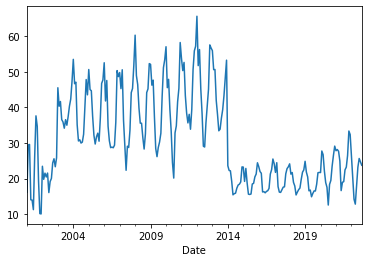

In [4]:
# dataset creation
#coal_data4=coal_data3.copy()
df = coal_data4.set_index("Date")
df['Coal_Con'].plot(style="-")

In [5]:
y=df['Coal_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


# Seasonal Naive Forecast model

In [6]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [7]:
import mlflow
import pandas as pd
import pmdarima as pm
# from fbprophet import Prophet
from prophet import Prophet

In [8]:
# Set up mlflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("forecasting-model-coal")
mlflow.tensorflow.autolog()

2023-02-25 22:50:36.447359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import matplotlib.pyplot as plt

2023/02/25 22:50:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Cmd('git') failed due to: exit code(1)
  cmdline: git version
  stderr: 'xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun'
2023/02/25 22:50:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Mean Absolute error is 14.060944444444443
MAPE is 35.906759468091494
RMSE is 17.92643451359947


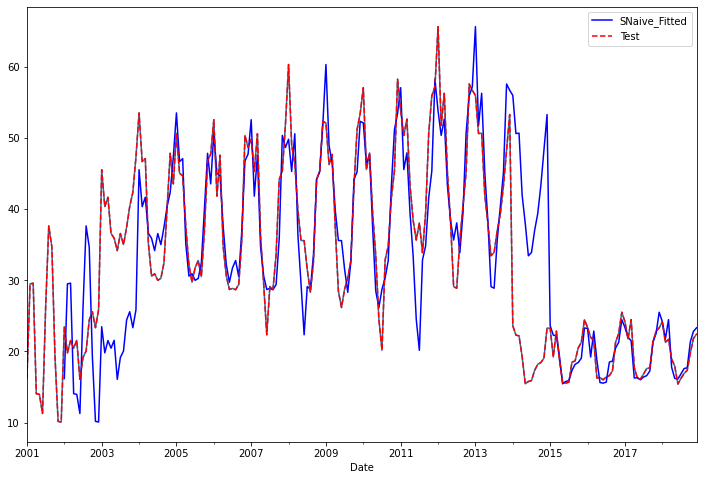

In [10]:

# Start mlflow run
with mlflow.start_run():
    mlflow.set_tag("data scientist", "kb")
    
   

    py_snaive_fit = pysnaive(train["Coal_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[0]

    #forecast
    py_snaive = pysnaive(train["Coal_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[1]

    #Residuals
    py_snaive_resid = (train["Coal_Con"] - py_snaive_fit).dropna()



    predictions=train.copy()
    predictions["py_snaive"] = py_snaive.values 


    predictions

    # Charting the output
    pd.plotting.register_matplotlib_converters()
    fig = plt.figure(figsize=(10,5)) 
    train["Coal_Con"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
    py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
    predictions["Coal_Con"].plot(style="--",color="r", legend=True, label="Test")
    #predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");


    #MAE
    n=mean_absolute_error(predictions["Coal_Con"], predictions["py_snaive"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((predictions["Coal_Con"] - predictions["py_snaive"]) / predictions["Coal_Con"])) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(predictions["Coal_Con"], predictions["py_snaive"]))
    print("RMSE is",r)
    
    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "py_snaive")
    #mlflow.set_tag("model", py_snaive_fit)
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "seasonal-naive.png")
    
    
    # Save model as artifact
    mlflow.sklearn.log_model(py_snaive_fit, "model")

# Holt-Winter's Method

Mean Absolute error is 6.655759199867149
MAPE is 28.266456932803706
RMSE is 8.103982670064289


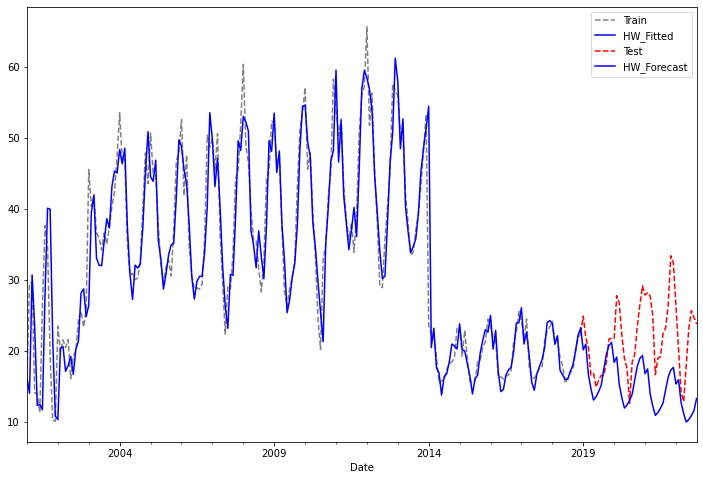

In [11]:
with mlflow.start_run():

    hw_model = ExponentialSmoothing(train["Coal_Con"],
                              trend    ="mul",
                              seasonal = "mul", 
                              seasonal_periods=12).fit()

    hw_fitted = hw_model.fittedvalues

    hw_resid = hw_model.resid

    #Adding the mean of the residuals to correct the bias.
    py_hw = hw_model.forecast(len(test["Coal_Con"]))+np.mean(hw_resid)
    py_hw=pd.DataFrame(py_hw)
    py_hw.columns=['py_hw']
    py_hw=py_hw.reset_index()
    py_hw=py_hw.drop('index',axis=1)
    predictions1=test.copy()
    predictions1=predictions1.reset_index()
    py_hw2 = pd.concat([predictions1,py_hw],axis=1)
    py_hw2=py_hw2.set_index('Date')
    py_hw2

    fig = plt.figure(figsize=(10,5))
    train["Coal_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
    py_hw2["Coal_Con"].plot(style="--",color="r", legend=True, label="Test")
    py_hw2["py_hw"].plot(color="b", legend=True, label="HW_Forecast")

    #MAE
    n=mean_absolute_error(py_hw2.Coal_Con, py_hw2["py_hw"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((py_hw2.Coal_Con - py_hw2["py_hw"]) / py_hw2.Coal_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(py_hw2.Coal_Con, py_hw2["py_hw"]))
    print("RMSE is",r)
    mlflow.log_param("model", "Holt-Winter")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Holt-winter.png")
    # Save model as artifact
    mlflow.sklearn.log_model(hw_model, "model")

# ETS Model

In [12]:
#coal_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\coal\\Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=pd.read_csv("Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=coal_data.rename(columns={'Series ID: ELEC.CONS_TOT.COW-AK-96.M thousand tons':'Coal_Con'})
mean_values = (coal_data['Coal_Con'].shift() + coal_data['Coal_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
coal_data['Coal_Con'].fillna(mean_values, inplace=True)
coal_data['D'] = coal_data['Month'].str.slice(0, 2)
coal_data['M'] = coal_data['Month'].str.slice(3, 5)
coal_data['Y'] = coal_data['Month'].str.slice(6, 10)
coal_data['Date1'] = coal_data['Y']+'-'+coal_data['M']+'-'+coal_data['D']
coal_data['Date'] = pd.to_datetime(coal_data['Date1'])
coal_data3=coal_data.sort_values(['Date'],ascending=True)
coal_data4=coal_data3[['Month','Coal_Con']]
df = coal_data4.set_index("Month")
y=df['Coal_Con']
y_to_val = y['01-12-2018':] # dataset to train
y_to_train = y[:'01-12-2018'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31878D+00    |proj g|=  1.51471D-01


 This problem is unconstrained.



At iterate    5    f=  2.98999D+00    |proj g|=  4.32709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   7.308D-07   2.983D+00
  F =   2.9828599299877760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Absolute error is 7.373995193571041
MAPE is 34.143339625744275
RMSE is 8.613862319417905


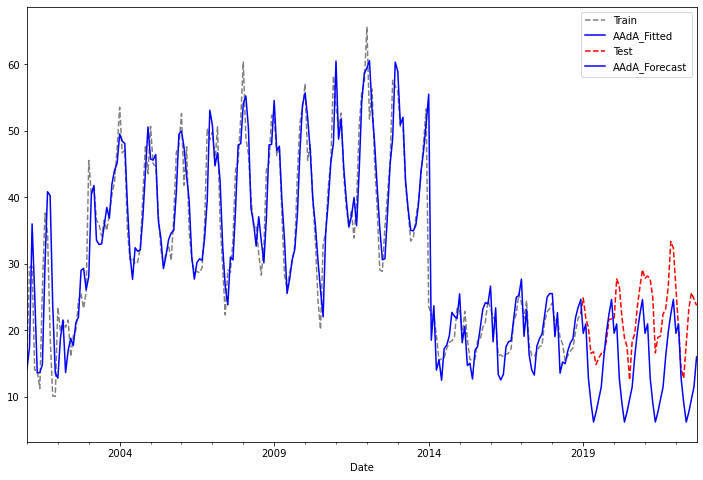

In [13]:
with mlflow.start_run():

    ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train["Coal_Con"],
                                               trend=True, 
                                               initialization_method= 'concentrated', 
                                               seasonal=12, 
                                               damped_trend=True).fit()

    fc_AAdA=ets_AAdA.forecast(len(test))

    fc_AAdA=pd.DataFrame(fc_AAdA)
    fc_AAdA.columns=['fc_AAdA']
    fc_AAdA=fc_AAdA.reset_index()
    fc_AAdA=fc_AAdA.drop('index',axis=1)
    predictions2=test.copy()
    predictions2=predictions2.reset_index()
    fc_AAdA2 = pd.concat([predictions2,fc_AAdA],axis=1)
    fc_AAdA2=fc_AAdA2.set_index('Month')
    fc_AAdA2=fc_AAdA2.reset_index()
    fc_AAdA2['D'] = fc_AAdA2['Month'].str.slice(0, 2)
    fc_AAdA2['M'] = fc_AAdA2['Month'].str.slice(3, 5)
    fc_AAdA2['Y'] = fc_AAdA2['Month'].str.slice(6, 10)
    fc_AAdA2['Date1'] = fc_AAdA2['Y']+'-'+fc_AAdA2['M']+'-'+fc_AAdA2['D']
    fc_AAdA2['Date'] = pd.to_datetime(fc_AAdA2['Date1'])
    fc_AAdA2=fc_AAdA2[['Date','Coal_Con','fc_AAdA']]
    fc_AAdA2=fc_AAdA2.set_index('Date')
    fc_AAdA2

    ets_AAdA2=pd.DataFrame(ets_AAdA.fittedvalues)
    ets_AAdA2=ets_AAdA2.reset_index()
    ets_AAdA2['D'] = ets_AAdA2['Month'].str.slice(0, 2)
    ets_AAdA2['M'] = ets_AAdA2['Month'].str.slice(3, 5)
    ets_AAdA2['Y'] = ets_AAdA2['Month'].str.slice(6, 10)
    ets_AAdA2['Date1'] = ets_AAdA2['Y']+'-'+ets_AAdA2['M']+'-'+ets_AAdA2['D']
    ets_AAdA2['Date'] = pd.to_datetime(ets_AAdA2['Date1'])
    ets_AAdA2=ets_AAdA2[['Date',0]]
    ets_AAdA2=ets_AAdA2.set_index('Date')
    ets_AAdA2

    train2=train.reset_index()
    train2['D'] = train2['Month'].str.slice(0, 2)
    train2['M'] = train2['Month'].str.slice(3, 5)
    train2['Y'] = train2['Month'].str.slice(6, 10)
    train2['Date1'] = train2['Y']+'-'+train2['M']+'-'+train2['D']
    train2['Date'] = pd.to_datetime(train2['Date1'])
    train2=train2[['Date','Coal_Con']]
    train2=train2.set_index('Date')
    train2

    #Plotting
    fig = plt.figure(figsize=(10,5))
    train2["Coal_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    ets_AAdA2[0].plot(color="b", legend=True, label="AAdA_Fitted")
    fc_AAdA2["Coal_Con"].plot(style="--",color="r", legend=True, label="Test")
    fc_AAdA2["fc_AAdA"].plot(color="b", legend=True, label="AAdA_Forecast")

    #MAE
    n=mean_absolute_error(fc_AAdA2.Coal_Con, fc_AAdA2["fc_AAdA"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((fc_AAdA2.Coal_Con - fc_AAdA2["fc_AAdA"]) / fc_AAdA2.Coal_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(fc_AAdA2.Coal_Con, fc_AAdA2["fc_AAdA"]))
    print("RMSE is",r)

    mlflow.log_param("model", "ETS")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "my-plot.png")
    # Save model as artifact
    mlflow.sklearn.log_model(ets_AAdA, "model")

# SARIMA

In [14]:
#coal_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\coal\\Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=pd.read_csv("Total_consumption_coal_Alaska_all_commercial_(total)_monthly.csv")
coal_data=coal_data.rename(columns={'Series ID: ELEC.CONS_TOT.COW-AK-96.M thousand tons':'Coal_Con'})
mean_values = (coal_data['Coal_Con'].shift() + coal_data['Coal_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
coal_data['Coal_Con'].fillna(mean_values, inplace=True)
coal_data['D'] = coal_data['Month'].str.slice(0, 2)
coal_data['M'] = coal_data['Month'].str.slice(3, 5)
coal_data['Y'] = coal_data['Month'].str.slice(6, 10)
coal_data['Date1'] = coal_data['Y']+'-'+coal_data['M']+'-'+coal_data['D']
coal_data['Date'] = pd.to_datetime(coal_data['Date1'])
coal_data3=coal_data.sort_values(['Date'],ascending=True)
coal_data4=coal_data3[['Date','Coal_Con']]
df = coal_data4.set_index("Date")
y=df['Coal_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


In [15]:
# determining the parameters
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
               
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91171D+00    |proj g|=  8.76955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.431D-07   4.912D+00
  F =   4.9117037772124457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17617D+00    |proj g|=  1.79127D-01

At iterate    5    f=  3.15241D+00    |proj g|=  5.00320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   1.541D-07   3.152D+00
  F =   3.1524089340803205     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39418D+00    |proj g|=  7.91791D-01

At iterate    5    f=  3.36232D+00    |proj g|=  3.19832D-01

At iterate   10    f=  3.34908D+00    |proj g|=  4.08672D-01

At iterate   15    f=  3.33444D+00    |proj g|=  1.57052D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   2.661D-06   3.334D+00
  F =   3.3344377963167573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  3.13362D+00    |proj g|=  1.03076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   3.156D-06   3.134D+00
  F =   3.1336022386265285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62383D+00    |proj g|=  3.99127D-01

At iterate    5    f=  4.39177D+00    |proj g|=  4.10376D-01

At iterate   10    f=  4.33974D+00    |proj g|=  1.97470D-02

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.90784D+00    |proj g|=  2.03454D+00

At iterate   15    f=  3.72378D+00    |proj g|=  6.11292D-02

At iterate   20    f=  3.72325D+00    |proj g|=  3.76312D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     31      1     0     0   3.763D-06   3.723D+00
  F =   3.7232459723937597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11052D+00    |proj g|=  3.58777D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92984D+00    |proj g|=  3.11267D-01

At iterate    5    f=  2.89217D+00    |proj g|=  1.20243D-01

At iterate   10    f=  2.88208D+00    |proj g|=  1.13981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   7.352D-06   2.882D+00
  F =   2.8820760776620582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  3.34686D+00    |proj g|=  9.64123D-01

At iterate   20    f=  3.10651D+00    |proj g|=  1.95848D-01

At iterate   25    f=  3.09066D+00    |proj g|=  2.81897D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     49      1     0     0   2.044D-07   3.091D+00
  F =   3.0906584568032809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29448D+00    |proj g|=  7.46846D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  3.56217D+00    |proj g|=  3.42880D+00

At iterate   15    f=  3.09034D+00    |proj g|=  7.88417D-01

At iterate   20    f=  3.06354D+00    |proj g|=  1.40212D-01

At iterate   25    f=  3.05254D+00    |proj g|=  1.48415D-02

At iterate   30    f=  3.05126D+00    |proj g|=  6.09518D-03

At iterate   35    f=  3.05121D+00    |proj g|=  4.94226D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     52      1     0     0   1.715D-06   3.051D+00
  F =   3.0512132036510073     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   2.317D-06   2.932D+00
  F =   2.9315008499051856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92898D+00    |proj g|=  3.14555D-01


 This problem is unconstrained.



At iterate    5    f=  2.88395D+00    |proj g|=  1.90422D-01

At iterate   10    f=  2.85865D+00    |proj g|=  1.44002D-02

At iterate   15    f=  2.85754D+00    |proj g|=  3.32214D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   3.322D-06   2.858D+00
  F =   2.8575362957988086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13212D+00    |proj g|=  2.28752D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94599D+00    |proj g|=  2.90520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   2.754D-06   2.946D+00
  F =   2.9459245168004013     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.6

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.76926D+00    |proj g|=  6.92346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   7.494D-06   2.769D+00
  F =   2.7692617319788591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69089D+00    |proj g|=  6.17364D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62465D+00    |proj g|=  6.23555D-02

At iterate    5    f=  2.60381D+00    |proj g|=  1.05942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   3.390D-06   2.604D+00
  F =   2.6037224454489452     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11678D+00    |proj g|=  3.72229D-02

At iterate    5    f=  3.11612D+00    |proj g|=  1.75592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   3.067D-07   3.116D+00
  F =   3.1161185584753466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   7.967D-06   2.838D+00
  F =   2.8375916282077016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91657D+00    |proj g|=  2.96125D-02

At iterate    5    f=  2.91569D+00    |proj g|=  1.72946D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.80448D+00    |proj g|=  2.38775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.976D-06   2.804D+00
  F =   2.8040343824467509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81072D+00    |proj g|=  1.55161D-01

At iterate    5    f=  2.77437D+00    |proj g|=  4.65281D-02

At iterate   10    f=  2.75201D+00    |proj g|=  2.73775D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.356D-06   2.669D+00
  F =   2.6693163118483829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63003D+00    |proj g|=  7.52563D-02

At iterate    5    f=  2.58216D+00    |proj g|=  4.50746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06009D+00    |proj g|=  1.30727D+00

At iterate    5    f=  2.87402D+00    |proj g|=  4.44429D-02

At iterate   10    f=  2.85360D+00    |proj g|=  4.04527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   9.469D-07   2.854D+00
  F =   2.8535970640193593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   1.134D-05   2.915D+00
  F =   2.9153393943025838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67401D+00    |proj g|=  1.69549D-01

At iterate    5    f=  2.63031D+00    |proj g|=  4.20250D-02

At iterate   10    f=  2.61599D+00    |proj g|=  8.89730D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.82936D+00    |proj g|=  1.12024D-01

At iterate   10    f=  2.79920D+00    |proj g|=  8.78162D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.199D-06   2.799D+00
  F =   2.7991520389497362     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89360D+00    |proj g|=  4.00085D-01

At iterate    5    f=  2.82081D+00    |proj g|=  6.02234D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  2.64579D+00    |proj g|=  6.09806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   4.145D-06   2.646D+00
  F =   2.6455664918536472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67278D+00    |proj g|=  2.01148D-01


 This problem is unconstrained.



At iterate    5    f=  2.58812D+00    |proj g|=  6.62565D-02

At iterate   10    f=  2.58170D+00    |proj g|=  2.14804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   1.860D-05   2.582D+00
  F =   2.5816974798413228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12210D+00    |proj g|=  2.40354D-02

At iterate    5    f=  3.12183D+00    |proj g|=  5.71283D-03

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88680D+00    |proj g|=  3.34805D-03

At iterate    5    f=  2.88672D+00    |proj g|=  3.58416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   5.205D-07   2.887D+00
  F =   2.8867090410860672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65316D+00    |proj g|=  1.73338D-01

At iterate    5    f=  2.60924D+00    |proj g|=  3.46257D-02

At iterate   10    f=  2.59985D+00    |proj g|=  1.18736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.768D-06   2.600D+00
  F =   2.5998473308409791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.79016D+00    |proj g|=  6.58297D-02

At iterate   10    f=  2.75000D+00    |proj g|=  8.42676D-02

At iterate   15    f=  2.74917D+00    |proj g|=  1.04500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   8.447D-06   2.749D+00
  F =   2.7491659716673564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70607D+00    |proj g|=  3.14376D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   1.047D-05   2.638D+00
  F =   2.6379577333605710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65102D+00    |proj g|=  1.93410D-01


 This problem is unconstrained.



At iterate    5    f=  2.56939D+00    |proj g|=  2.13149D-01

At iterate   10    f=  2.56498D+00    |proj g|=  4.24760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   4.892D-07   2.565D+00
  F =   2.5649772906396411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12487D+00    |proj g|=  5.14042D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.84781D+00    |proj g|=  3.29184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   3.853D-06   2.847D+00
  F =   2.8470459042285490     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93294D+00    |proj g|=  5.10179D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  2.62729D+00    |proj g|=  6.18449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   3.940D-06   2.627D+00
  F =   2.6272569479443080     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83295D+00    |proj g|=  1.24637D-01

At iterate    5    f=  2.78524D+00    |proj g|=  1.16480D-02


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   6.314D-07   2.785D+00
  F =   2.7850128074574250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82573D+00    |proj g|=  1.49186D-01

At iterate    5    f=  2.78075D+00    |proj g|=  6.43903D-02

At iterate   10    f=  2.76185D+00    |proj g|=  1.33288D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.66040D+00    |proj g|=  1.21130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.122D-06   2.660D+00
  F =   2.6603977304335280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64701D+00    |proj g|=  6.50736D-02

At iterate    5    f=  2.59961D+00    |proj g|=  4.85279D-02

At iterate   10    f=  2.59467D+00    |proj g|=  3.22148D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.83701D+00    |proj g|=  5.45131D-02

At iterate   20    f=  2.82394D+00    |proj g|=  2.64505D-01

At iterate   25    f=  2.82289D+00    |proj g|=  5.81817D-02

At iterate   30    f=  2.82271D+00    |proj g|=  5.67589D-02

At iterate   35    f=  2.82257D+00    |proj g|=  1.28160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     58      1     0     0   5.532D-05   2.823D+00
  F =   2.8225691178592198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.89243D+00    |proj g|=  5.29011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.723D-05   2.892D+00
  F =   2.8924304724731198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62240D+00    |proj g|=  6.92558D-02

At iterate    5    f=  2.59725D+00    |proj g|=  8.80343D-02

At iterate   10    f=  2.59317D+00    |proj g|=  1.54870D-04

       

 This problem is unconstrained.



At iterate    5    f=  2.78586D+00    |proj g|=  2.52987D-02

At iterate   10    f=  2.78485D+00    |proj g|=  7.33236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   8.336D-06   2.785D+00
  F =   2.7848008974387857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81105D+00    |proj g|=  1.52382D-01


 This problem is unconstrained.



At iterate    5    f=  2.77547D+00    |proj g|=  4.83400D-02

At iterate   10    f=  2.75203D+00    |proj g|=  8.33206D-03

At iterate   15    f=  2.75201D+00    |proj g|=  7.25406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   7.217D-07   2.752D+00
  F =   2.7520080590826712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65421D+00    |proj g|=  4.20943D-02

At iterate    5    f=  2.63657D+00    |proj g|=  1.84581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   2.770D-06   2.636D+00
  F =   2.6362093836686853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  2.58249D+00    |proj g|=  9.91320D-02

At iterate   10    f=  2.56836D+00    |proj g|=  2.35233D-03

At iterate   15    f=  2.56835D+00    |proj g|=  2.12564D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   9.360D-06   2.568D+00
  F =   2.5683535230119179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:1348.9181457138927


In [16]:
import pmdarima as pm

In [17]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    fig = plt.figure(figsize=(10,5))
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    k=mean_absolute_error(y_forecasted, y_to_test)
    n=np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print("Mean Absolute error :",k)
    print("MAPE is :",n)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))
    fig1 = plt.figure(figsize=(10,5))
    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    k_dynamic=mean_absolute_error(y_forecasted_dynamic, y_to_test)
    n_dynamic=np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    r=round(np.sqrt(mse_dynamic), 2)
    print("Mean Absolute error :",k_dynamic)
    print("MAPE is :",n_dynamic)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))
    fig2 = plt.figure(figsize=(10,5))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    with mlflow.start_run():
        #log the params
        mlflow.log_param("model", "SARIMA")
        #log the metrics
        mlflow.log_metric("mae", k_dynamic)
        mlflow.log_metric("mape", n_dynamic)
        mlflow.log_metric("rmse", r)
        #log the plot
        mlflow.log_figure(fig2, "my-plot.png")
        # Save model as artifact
        mlflow.pmdarima.log_model(results, "model")
    
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65102D+00    |proj g|=  1.93410D-01


 This problem is unconstrained.



At iterate    5    f=  2.56939D+00    |proj g|=  2.13149D-01

At iterate   10    f=  2.56498D+00    |proj g|=  4.24760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   4.892D-07   2.565D+00
  F =   2.5649772906396411     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9033      0.036     24.749      0.000       0.832       0.975
ma.L1         -0.1412      0.084     -1.683      0.092      -0

<Figure size 720x360 with 0 Axes>

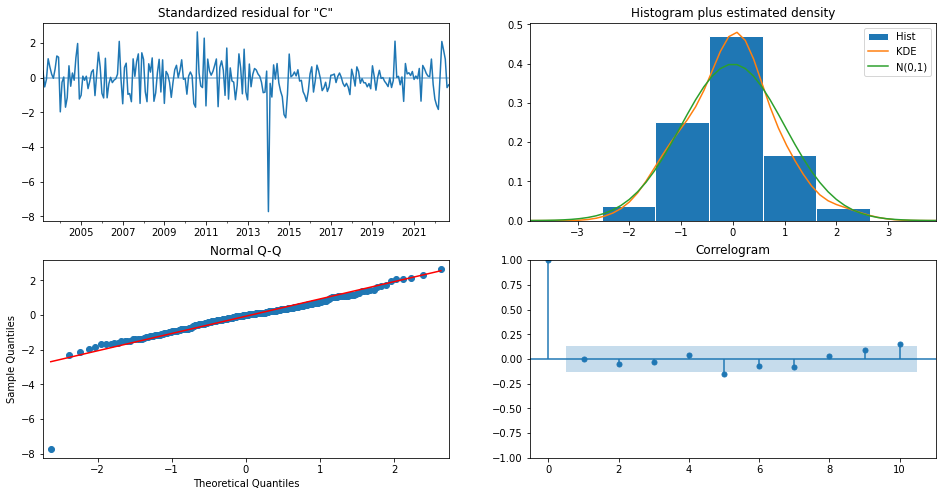

Mean Absolute error : 2.3258687104600897
MAPE is : 11.488634065160902
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 3.32


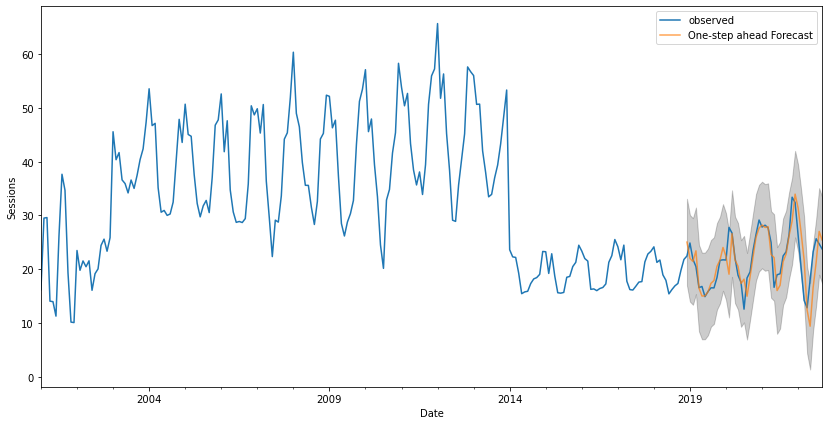

Mean Absolute error : 2.866328534128449
MAPE is : 13.954387000707854
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 3.79


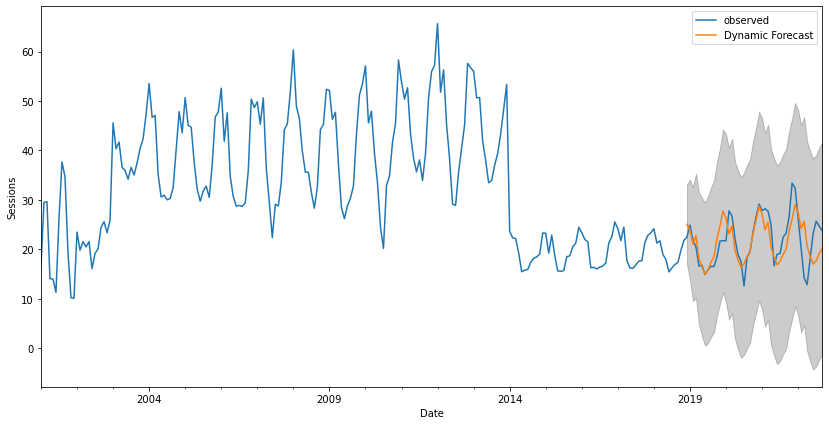

In [18]:
model = sarima_eva(y,(1, 0, 1),(1, 1, 1, 12),12,'2018-12-01',y_to_val)

In [19]:
# consumption forecasting
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int()
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    
    
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    
    pci2=pci.set_index('Date')
    pm2=pm.set_index('Date')
    ax = y.plot(label='observed', figsize=(14, 7))
    pm2.plot(ax=ax, label='Forecast')
    ax.fill_between(pci2.index,
                    pci2.iloc[:, 0],
                    pci2.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    final_table = pm.join(pci.set_index('Date'), on='Date')
    final_table=final_table.set_index('Date')
    return (final_table)

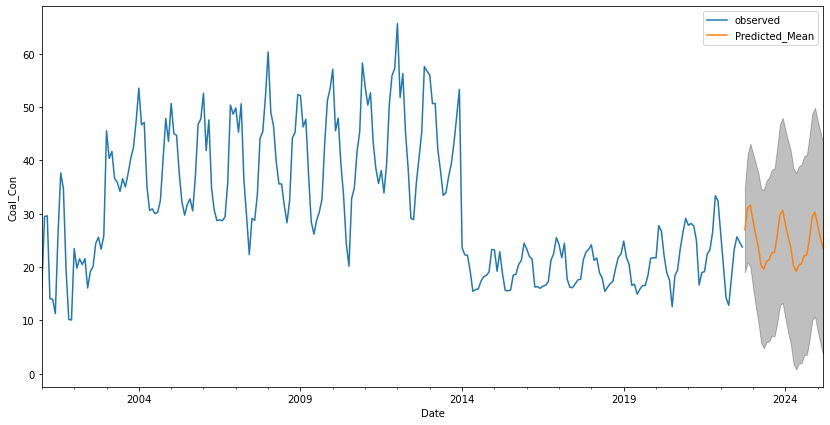

In [20]:
forecast_table = forecast(model,30,y)

In [21]:
forecast_table.to_csv('forecast_coal_values.csv')